<a href="https://colab.research.google.com/github/aniketmaurya/pytorch-gans/blob/main/pix2pix/Pix2Pix_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q pytorch-lightning

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
import os
from glob import glob
from pathlib import Path
from PIL import Image

In [4]:
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 20

display_step = 200
batch_size = 4
lr = 0.0002
target_size = 256
device = 'cuda'

In [5]:
import pytorch_lightning as pl

In [6]:
def show_tensor_images(image_tensor,
                       num_images=25,
                       size=(3, 64, 64),
                       ret=False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    if ret:
        return image_grid.permute(1, 2, 0).squeeze()
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [7]:
from torchvision import transforms

In [8]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
# !tar -xvf facades.tar.gz

In [9]:
# http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
path = './facades/train/'

class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(str(Path(path)/'*'))
        self.target_size = target_size
        
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]        
        
        real = image[:, :, :image_width // 2]
        condition = image[:, :, image_width // 2:]
        
        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)
        
        return real, condition
    
    
dataset = FacadesDataset(path, target_size=target_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
transforms.functional.to_pil_image(dataset[0][0])
transforms.functional.to_pil_image(dataset[0][0]).size
dataset[0][0].shape

torch.Size([3, 256, 256])

In [10]:
def _center_crop(image, new_shape):
    h, w = image.shape[-2:]
    n_h, n_w = new_shape[-2:]
    cy, cx = int(h / 2), int(w / 2)
    xmin, ymin = cx - n_w // 2, cy - n_h // 2
    xmax, ymax = xmin + n_w, ymin + n_h
    cropped_image = image[..., xmin:xmax, ymin:ymax]
    return cropped_image


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)

        if use_bn:
            self.batchnorm = nn.BatchNorm2d(out_channels)
        self.use_bn = use_bn

        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x


class UpSampleConv(nn.Module):

    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):

        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = _center_crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x


class DownSampleConv(nn.Module):

    def __init__(self, in_channels, use_dropout=False, use_bn=False):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        if use_bn:
            self.batchnorm = nn.BatchNorm2d(in_channels * 2)
        self.use_bn = use_bn

        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

        self.conv_block1 = ConvBlock(in_channels, in_channels * 2, use_dropout, use_bn)
        self.conv_block2 = ConvBlock(in_channels * 2, in_channels * 2, use_dropout, use_bn)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.maxpool(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32, depth=6):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1)

        self.conv_final = nn.Conv2d(hidden_channels,
                                    out_channels,
                                    kernel_size=1)
        self.depth = depth

        self.contracting_layers = []
        self.expanding_layers = []
        self.sigmoid = nn.Sigmoid()

        # encoding/contracting path of the Generator
        for i in range(depth):
            down_sample_conv = DownSampleConv(hidden_channels * 2 ** i,
                                              use_dropout=(True if i < 3 else False))
            self.contracting_layers.append(down_sample_conv)

        # Upsampling/Expanding path of the Generator
        for i in range(depth):
            upsample_conv = UpSampleConv(hidden_channels * 2 ** (i + 1))
            self.expanding_layers.append(upsample_conv)

        self.contracting_layers = nn.ModuleList(self.contracting_layers)
        self.expanding_layers = nn.ModuleList(self.expanding_layers)

    def forward(self, x):
        depth = self.depth
        contractive_x = []

        x = self.conv1(x)
        contractive_x.append(x)

        for i in range(depth):
            x = self.contracting_layers[i](x)
            contractive_x.append(x)

        for i in range(depth - 1, -1, -1):
            x = self.expanding_layers[i](x, contractive_x[i])
        x = self.conv_final(x)

        return self.sigmoid(x)


class PatchGAN(nn.Module):

    def __init__(self, input_channels, hidden_channels=8):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=1)
        self.contract1 = DownSampleConv(hidden_channels, use_bn=False)
        self.contract2 = DownSampleConv(hidden_channels * 2)
        self.contract3 = DownSampleConv(hidden_channels * 4)
        self.contract4 = DownSampleConv(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.conv1(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn


In [11]:
gen = Generator(3, 3)

In [12]:
x = torch.randn(1, 1024, 7, 7)

In [13]:
gen(torch.randn(2, 3, 256, 256)).shape

torch.Size([2, 3, 256, 256])

In [14]:
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [15]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [16]:
class Pix2Pix(pl.LightningModule):
    def __init__(self,
                 in_channels,
                 out_channels,
                 hidden_channels=32,
                 depth=6,
                 learning_rate=0.0002,
                 lambda_recon=200):

        super().__init__()
        self.save_hyperparameters()

        self.gen = Generator(in_channels, out_channels, hidden_channels, depth)
        self.patch_gan = PatchGAN(in_channels + out_channels, hidden_channels=8)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch

        loss = None
        if optimizer_idx == 0:
            loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', loss)
        elif optimizer_idx == 1:
            loss = self._gen_step(real, condition)
            self.log('Generator Loss', loss)
        
        if self.current_epoch%10==0 and batch_idx==99 and optimizer_idx==1:
            fake = self.gen(condition).detach()
            show_tensor_images(real[0])
            show_tensor_images(fake[0])
        return loss

In [17]:
pix2pix = Pix2Pix(3, 3)

In [18]:
trainer = pl.Trainer(max_epochs=100, gpus=1)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 117 M 
1 | patch_gan             | PatchGAN          | 294 K 
2 | adversarial_criterion | BCEWithLogitsLoss | 0     
3 | recon_criterion       | L1Loss            | 0     
------------------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params


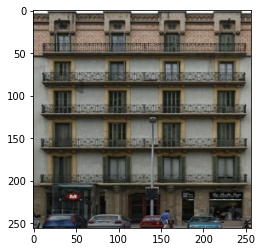

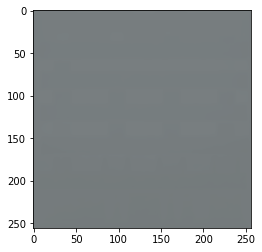

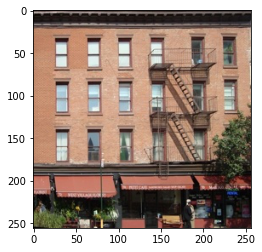

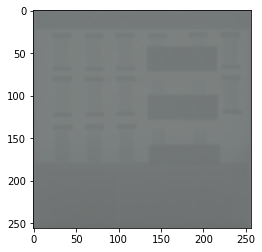

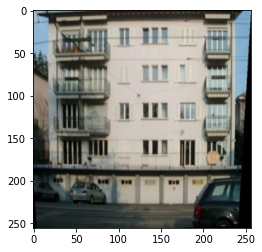

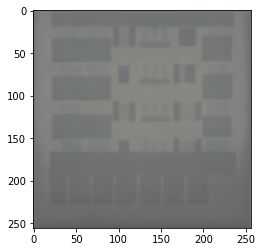

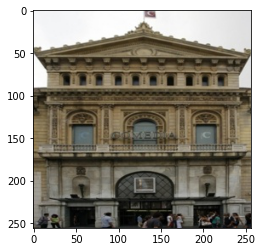

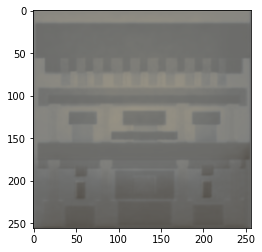

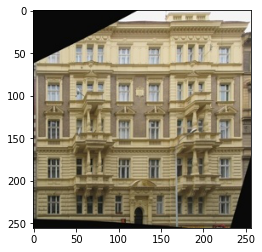

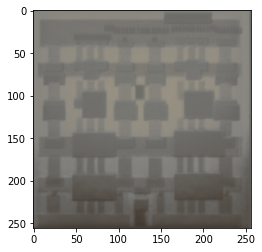

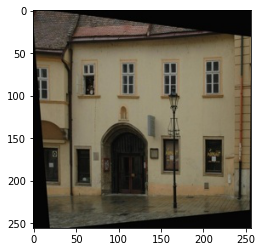

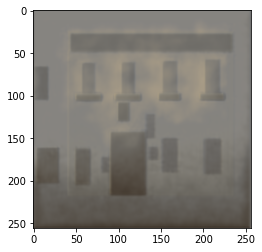

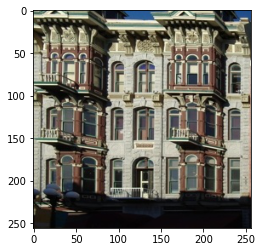

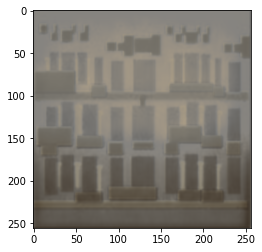

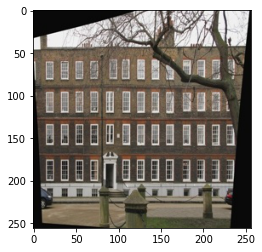

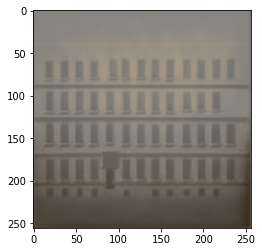

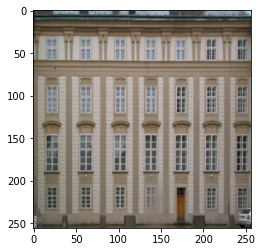

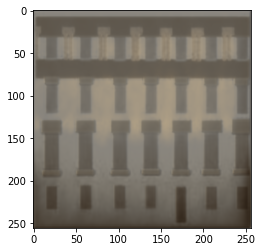

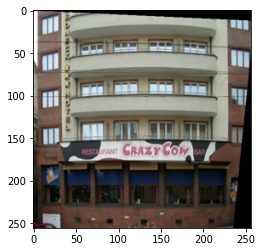

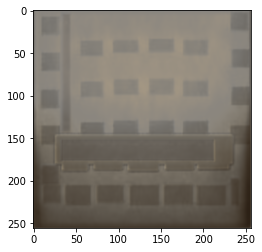

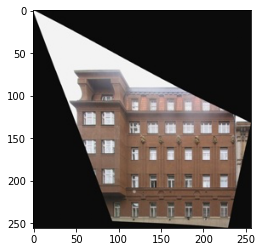

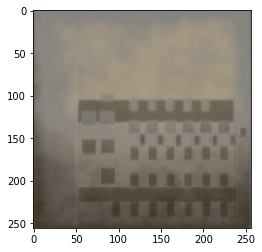

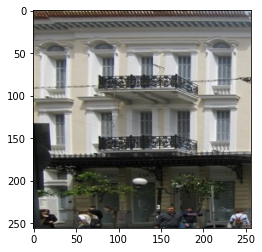

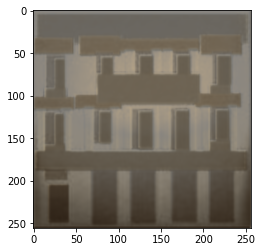

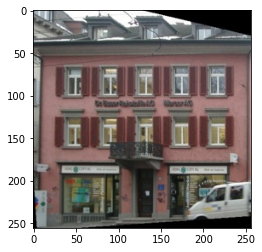

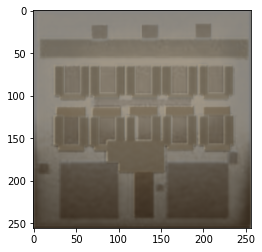

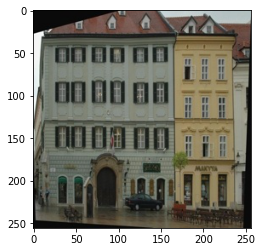

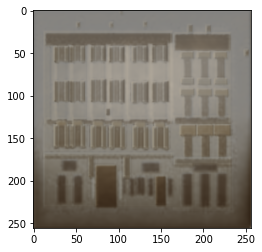

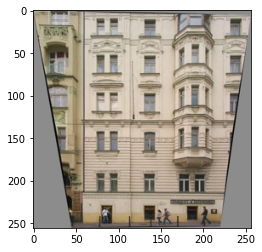

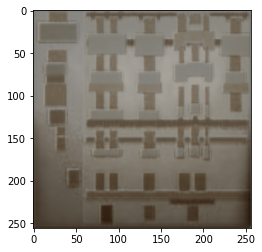

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [19]:
trainer.fit(pix2pix, dataloader)